In [92]:
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from scipy.ndimage import uniform_filter1d
from torch.utils.data import DataLoader
import methods_NN as NN
import torch
from tqdm import tqdm

# Plot setup
from pandas.plotting import register_matplotlib_converters
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
#register_matplotlib_converters()
#plt.rc("figure", figsize=(12, 8))
#plt.rc("font", size=13)

In [129]:
epochs = 20
learning_rate = 0.00001
batch_size = 151
smoking = True

In [130]:
# Data prep
# print(data_train.__len__()) #-> 2, 2, 2, 3, 3, 3, 7, 151
# print(data_test.__len__()) #-> 2, 2, 2, 3, 7, 151
data_train, data_test, label_train, label_test = NN.load_data("full", smoking=smoking)

label_train_reshaped = np.zeros((len(label_train), 2))
label_test_reshaped = np.zeros((len(label_test), 2))

for i, trn in enumerate(label_train):
    label_train_reshaped[i, int(trn)] = 1

for i, tst in enumerate(label_test):
    label_test_reshaped[i, int(tst)] = 1

data_train = NN.NumbersDataset(data_train, label_train_reshaped)
data_test = NN.NumbersDataset(data_test, label_test_reshaped)

loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True, pin_memory=True)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True, pin_memory=True)

In [131]:
# Hyperparams and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [132]:
# Model prep
model = NN.Network(
    hidden_layer_dims=[500, 125],
    input_size=21,
    device=device
).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [133]:
# Train the data
num_steps = len(loader_train)
loss_list = list()

for epoch in tqdm(range(epochs)):
    for i, (value, label) in enumerate(loader_train):
        sample = value.reshape(batch_size, -1).to(device)
        label = label.view(label.shape[0], 2).to(device)
        
        # forward
        output = model(sample)
        loss = criterion(output, label)
        loss_list.append(loss.item())
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


In [134]:
# Test the data
with torch.no_grad():
    out_list = []
    label_list = []

    labs1d = []
    pred1d = []
    n_samples = 0
    n_diff = 0
    
    for value, label in loader_test:
        sample = value.to(device)
        label = label.view(label.shape[0], 2).to(device)
        label_list += label.tolist()
        
        output = model(sample)
        out_list += output.tolist()
        _, pred = torch.max(output, 1)
        _, labs = torch.max(label, 1)
        n_diff += torch.abs(pred-labs)

        pred1d += pred.tolist()
        labs1d += labs.tolist()

        n_samples += 1
    
    #acc = n_diff/n_samples
pred1d = np.array(pred1d)
labs1d = np.array(labs1d)

In [135]:
#print(len(np.where(np.array(out_list).T[0]==0)[0]), len(np.array(out_list).T[0]))

acc = np.count_nonzero(pred1d == labs1d)/len(labs1d)
acc0 = (len(pred1d[np.where(labs1d==0)])-np.sum(pred1d[np.where(labs1d==0)]))/len(np.where(labs1d==0)[0])
acc1 = np.sum(pred1d[np.where(labs1d==1)])/len(np.where(labs1d==1)[0])

if smoking == True:
    label_name = "smoking"
else:
    label_name = "diabetes"

print(f"{acc*100:.5f}% overall accuracy")
print(f"{acc0*100:.5f}% of non {label_name} guessed correctly")
print(f"{acc1*100:.5f}% of {label_name} guessed correctly")


86.06906% overall accuracy
100.00000% of non smoking guessed correctly
0.00000% of smoking guessed correctly


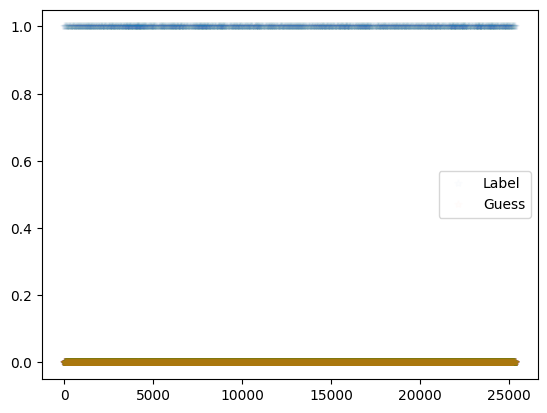

In [136]:
plt.plot(labs1d, '*', label='Label', alpha=0.01)
plt.plot(pred1d, '*', label='Guess', alpha=0.01)
plt.legend()
plt.show()

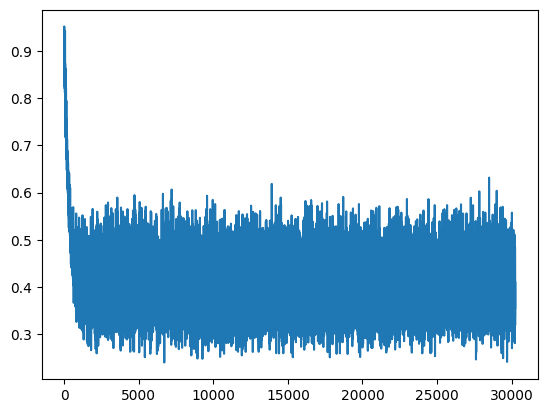

In [137]:
plt.plot(np.array(loss_list))
plt.show()